# Load data
First we load the data, I've pulled a [generic quotations dataset](https://huggingface.co/datasets/m-ric/english_historical_quotes/) from huggingface, it's downloaded to the repo for convenience.

In [2]:
import datasets
import sentence_transformers

dataset = datasets.load_dataset("m-ric/english_historical_quotes")

# Get quotes
labels = [item["quote"] for item in dataset["train"]]

model_string = "BAAI/bge-base-en-v1.5"
embedding_model = sentence_transformers.SentenceTransformer(model_string)
embeddings = embedding_model.encode(labels, show_progress_bar=True)

Batches:   0%|          | 0/751 [00:00<?, ?it/s]

In [3]:
import networkx as nx
from semnet import SemanticNetwork

sem = SemanticNetwork()

threshes = [i / 100 for i in list(range(-5, 70, 5))]
component_counts = []
for thresh in threshes:
    G = sem.fit_transform(
        embeddings=embeddings,
        labels=labels,
        thresh=thresh,
        top_k=20,
    )
    orphan_nodes = list(nx.isolates(G))
    component_counts.append(
        {
            "thresh": thresh,
            "n_orphans": len(orphan_nodes),
            "pct_orphans": (len(orphan_nodes) / G.number_of_nodes()),
            "n_edges": G.number_of_edges(),
        }
    )

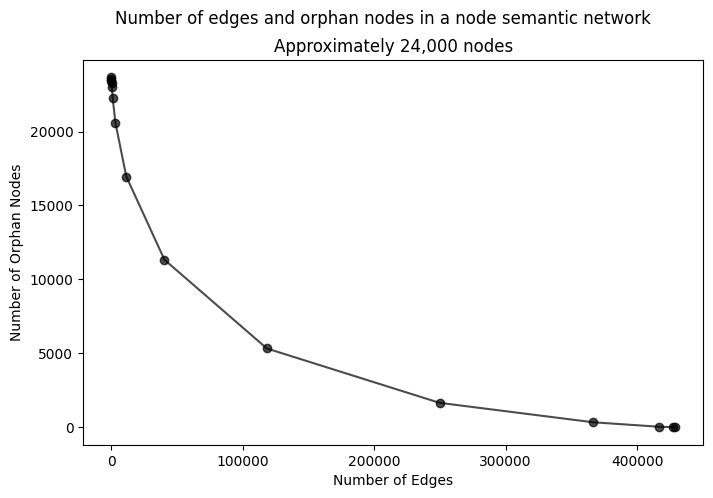

In [4]:
import matplotlib.pyplot as plt

edge_counts = [c["n_edges"] for c in component_counts]
orphan_counts = [c["n_orphans"] for c in component_counts]

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(edge_counts, orphan_counts, marker="o", color="black", alpha=0.7)

# # log scale for both axis
# ax.set_xscale("log")
# ax.set_yscale("log")


# Labels
ax.set_xlabel("Number of Edges")
ax.set_ylabel("Number of Orphan Nodes")

# ax.set_xlim(-1, 25_000)
# ax.set_xlim(-1000, 5_000_00)

# Titles
fig.suptitle("Number of edges and orphan nodes in a node semantic network")
ax.set_title("Approximately 24,000 nodes")

fig.savefig("orphan_nodes_vs_edges.png", dpi=300)
plt.show()

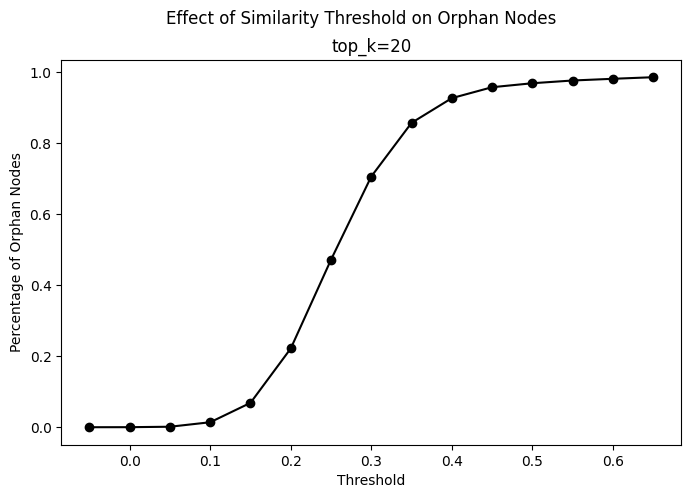

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    [item["thresh"] for item in component_counts],
    [item["pct_orphans"] for item in component_counts],
    marker="o",
    color="black",
)


# Labels
ax.set_xlabel("Threshold")
ax.set_ylabel("Percentage of Orphan Nodes")

# Titles
fig.suptitle("Effect of Similarity Threshold on Orphan Nodes")
ax.set_title("top_k=20")

fig.savefig("orphan_nodes_vs_threshold.png", dpi=300)
plt.show()

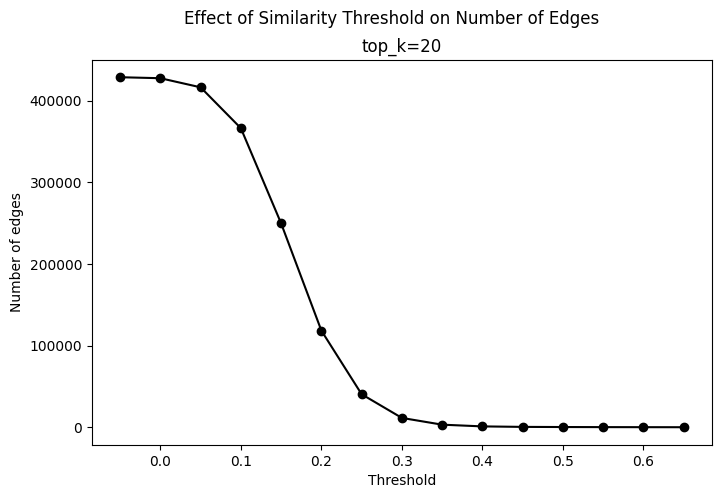

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    [item["thresh"] for item in component_counts],
    [item["n_edges"] for item in component_counts],
    marker="o",
    color="black",
)

# ax.axhline(len(labels), color="red", linestyle="--", label="Total Nodes")
# ax.text(0.32, len(labels) + 500, "Fully disconnected", color="red")
# ax.set_xlim(0, 0.5)
# ax.set_ylim(0, 30_000)

# Labels
ax.set_xlabel("Threshold")
ax.set_ylabel("Number of edges")

# Titles
fig.suptitle("Effect of Similarity Threshold on Number of Edges")
ax.set_title("top_k=20")

fig.savefig("edges_vs_threshold.png", dpi=300)
plt.show()

In [7]:
from semnet import SemanticNetwork, to_pandas

# Fit the network, passing in custom data
sem = SemanticNetwork()

# We can pass in arbitrary node data as a dictionary
node_data = {}
for n, item in enumerate(dataset["train"]):
    node_data[n] = {"author": item["author"], "foo": "bar"}

G = sem.fit_transform(
    embeddings=embeddings,
    labels=labels,  # labels can be optionally passed during fitting
    thresh=0.25,
    top_k=20,
    node_data=node_data,
)

In [8]:
print(f"G is of type: {type(G)}")
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()
print(f"G has {n_nodes} nodes and {n_edges} edges.")

import random

random.seed(123)

print("\nSample nodes:")
sample = random.sample(list(G.nodes(data=True)), 5)
for idx, node in sample:
    print(f"{node['author']}: {node['label'][:30]}...")

G is of type: <class 'networkx.classes.graph.Graph'>
G has 24022 nodes and 40559 edges.

Sample nodes:
Archimedes: Give me a lever long enough an...
Graham Greene: If you have abandoned one fait...
Betty White: My mother and dad were big ani...
Joyce Carol Oates: I could never take the idea of...
Gore Vidal: We must declare ourselves, bec...


In [9]:
print("\nSample edges:")
random.seed(123)
sample = random.sample(list(G.edges(data=True)), 5)
for u, v, edge in sorted(sample, key=lambda x: x[2]["weight"], reverse=True):
    quote_u = G.nodes[u]["label"][:30]
    quote_v = G.nodes[v]["label"][:30]
    print(f'"{quote_u}" {edge["weight"]:.2f} "{quote_v}"')


Sample edges:
"We extend our hand towards pea" 0.32 "Our object should be peace wit"
"Death is really a great blessi" 0.30 "Life is a great sunrise. I do "
"Love is the river of life in t" 0.26 "People think love is an emotio"
"No amount of skillful inventio" 0.25 "Anyone who lives within his me"
"I have a fine sense of the rid" 0.25 "I don't think humor is forced "


In [10]:
import networkx as nx

# Get connected components
components = list(nx.connected_components(G))
print(f"\nThe graph has {len(components)} connected components.")


# Count how many components of each size there are
from collections import Counter

component_sizes = [len(c) for c in components]
component_size_counts = Counter(component_sizes)

for size, count in sorted(component_size_counts.items(), reverse=True):
    print(f"Size {size}: {count} components")


The graph has 11854 connected components.
Size 11471: 1 components
Size 11: 1 components
Size 10: 1 components
Size 8: 1 components
Size 7: 3 components
Size 6: 3 components
Size 5: 5 components
Size 4: 17 components
Size 3: 76 components
Size 2: 416 components
Size 1: 11330 components


In [11]:
# Keep track of the old size
old_size = len(G.nodes)

# Use networkx to find the subgraph
subgraphs = list(nx.connected_components(G))
largest_subgraph = max(subgraphs, key=len)

# Reduce the graph down
G = G.subgraph(largest_subgraph).copy()

new_size = len(G.nodes)
print(
    f"""Reduced graph from {old_size} to {new_size}.
{old_size - new_size} nodes were removed."""
)

Reduced graph from 24022 to 11471.
12551 nodes were removed.


In [12]:
random.seed(1)

# Sample two random nodes
node_a, node_b = random.sample(list(G.nodes(data=True)), 2)

# Our weights are similarity scores, so we need to invert them for shortest path
weight_func = lambda u, v, d: 1 - d["weight"]

# Find shortest path
path = nx.shortest_path(G, source=node_a[0], target=node_b[0], weight=weight_func)

# Print the path
print("\nShortest path between two random nodes:\n")
print(f"Source: {node_a[1]['label'][:50]}...")
print(f"Target: {node_b[1]['label'][:50]}...")

for idx in path:
    if idx != node_a[0] and idx != node_b[0]:
        print(f"- {G.nodes[idx]['label'][:50]}...")


Shortest path between two random nodes:

Source: Traveling is seeing it is the implicit that we tra...
Target: Without God, democracy will not and cannot long en...
- To travel is to take a journey into yourself....
- Life isn't about finding yourself. Life is about c...
- The good life is a process, not a state of being. ...
- Life is made up of small pleasures. Happiness is m...
- Happiness is neither without us nor within us. It ...
- God cannot give us a happiness and peace apart fro...


In [13]:
# Get a node's neighbours
random.seed(1234)
sample_node = random.choice(list(G.nodes(data=True)))
neighbors = list(G.neighbors(sample_node[0]))

# Print the sample node and its neighbors
print(f"Sample node: {sample_node[1]['label'][:50]}...")
print("Neighbors:")
for neighbor in neighbors:
    print(f"- {G.nodes[neighbor]['label'][:50]}...")

Sample node: Anything in any way beautiful derives its beauty f...
Neighbors:
- If thou desire the love of God and man, be humble,...
- Beauty is but the sensible image of the Infinite. ...
- Beauty, like truth, is relative to the time when o...
- Man's only true happiness is to live in hope of so...
- The thought came to me that all one loves in art b...
- Love of beauty is taste. The creation of beauty is...
- An act of goodness is of itself an act of happines...
- Always think of what is useful and not what is bea...
- Beauty is an ecstasy it is as simple as hunger. Th...


In [14]:
# Calculate degree centrality for all nodes
import networkx as nx

# Calculate degree centrality for all nodes
centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, centrality, "degree_centrality")

# Calculate closeness centrality for all nodes
closeness = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness, "closeness_centrality")

# Calculate betweenness centrality for all nodes
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, "betweenness_centrality")

In [26]:
from semnet import to_pandas

nodes, edges = to_pandas(G)

# Sort nodes by closeness centrality
top_pr = nodes.sort_values(by="closeness_centrality", ascending=False)
print("Top 10 Influential Quotes by Closeness Centrality:\n")
for _, row in top_pr.head(10).iterrows():
    print(f'{row["label"][:50]}... [{row["closeness_centrality"]:.6f}]')

Top 10 Influential Quotes by Closeness Centrality:

Human nature is not of itself vicious.... [0.224541]
There are truths which are not for all men, nor fo... [0.221793]
Man is not the creature of circumstances, circumst... [0.219782]
Achieving life is not the equivalent of avoiding d... [0.218539]
Man's nature is not essentially evil. Brute nature... [0.216219]
Men are born to succeed, not to fail.... [0.215326]
Common sense is not so common.... [0.213451]
The good life is a process, not a state of being. ... [0.213173]
However great an evil immorality may be, we must n... [0.212561]
Wise men make more opportunities than they find.... [0.212553]


In [27]:
author_pr = (
    nodes.groupby("author")["closeness_centrality"]
    .mean()
    .reset_index()
    .sort_values(by="closeness_centrality", ascending=False)
    .head(10)
)

print("Top 10 Influential Authors by Closeness Centrality:\n")
for _, row in author_pr.iterrows():
    print(f'{row["author"][:50]}... [{row["closeness_centrality"]:.6f}]')

Top 10 Influential Authors by Closeness Centrality:

Curt Siodmak... [0.210328]
Amelia Edith Huddleston Barr... [0.210139]
Elizabeth Gaskell... [0.207463]
Conrad Hilton... [0.206443]
Maharishi Mahesh Yogi... [0.206354]
Willy Brandt... [0.206273]
Edmund Waller... [0.205740]
Conor Cruise O'Brien... [0.205721]
Morarji Desai... [0.205688]
Winifred Holtby... [0.202307]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

nodes, edges = to_pandas(G)

# Get louvain communities
communities = nx.community.louvain_communities(G)
for i, community in enumerate(communities):
    for node in community:
        G.nodes[node]["community"] = f"community_{i}"

# Apply to whole nodes table
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(nodes["label"])
terms = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X.toarray(), columns=terms)
tfidf_df["community"] = nodes["community"].values

top_terms = {}
for community in tfidf_df["community"].unique():
    community_df = tfidf_df[tfidf_df["community"] == community]

    # Get mean tf-idf per term in community
    m_tfidf = community_df.drop(columns=["community"]).mean()

    # Get top 3 terms
    com_terms = m_tfidf.sort_values(ascending=False).head(3).index.tolist()
    top_terms[community] = "_".join(com_terms)

for community, terms in top_terms.items():
    print(f"Top terms for {community}: {terms}")

nodes["community_label"] = nodes["community"].map(top_terms)
nodes["community_label"].value_counts()

Top terms for community_34: game_good_bad
Top terms for community_23: success_failure_best
Top terms for community_2: sports_game_like
Top terms for community_27: freedom_government_power
Top terms for community_11: knowledge_education_wisdom
Top terms for community_30: women_men_woman
Top terms for community_9: poetry_poet_write
Top terms for community_4: beauty_nature_beautiful
Top terms for community_13: war_peace_people
Top terms for community_12: marriage_married_love
Top terms for community_1: truth_anger_lie
Top terms for community_35: future_history_past
Top terms for community_16: politics_political_party
Top terms for community_20: death_life_fear
Top terms for community_0: god_work_health
Top terms for community_21: god_faith_religion
Top terms for community_32: happiness_life_happy
Top terms for community_24: men_man_great
Top terms for community_18: leadership_people_leader
Top terms for community_36: bad_good_feel
Top terms for community_19: love_friendship_friends
Top te

community_label
knowledge_education_wisdom        1111
god_faith_religion                 999
success_failure_best               892
freedom_government_power           762
happiness_life_happy               727
men_man_great                      693
war_peace_people                   564
love_friendship_friends            521
future_history_past                447
art_artist_architecture            435
courage_fear_strength              409
poetry_poet_write                  399
truth_anger_lie                    386
women_men_woman                    361
beauty_nature_beautiful            356
imagination_dreams_hope            278
god_work_health                    249
marriage_married_love              234
death_life_fear                    231
music_famous_people                201
money_society_health               197
humor_funny_sense                  194
politics_political_party           183
age_old_change                     179
leadership_people_leader           122
travel_wa

In [55]:
# Sample from within top 5 communities
for community in nodes["community_label"].value_counts().head(5).index:
    comm_df = nodes[nodes["community_label"] == community]
    sample_quotes = comm_df.sample(3, random_state=123)
    print(f"\nSample quotes from community '{community}' ({len(comm_df)} items):\n")
    for _, row in sample_quotes.iterrows():
        print(f'- {row["label"][:100]}...')


Sample quotes from community 'knowledge_education_wisdom' (1111 items):

- The ultimate goal of the educational system is to shift to the individual the burden of pursing his ...
- A prudent question is one-half of wisdom....
- Any intelligent fool can make things bigger and more complex... It takes a touch of genius - and a l...

Sample quotes from community 'god_faith_religion' (999 items):

- If you don't do your part, don't blame God....
- The investigator should have a robust faith - and yet not believe....
- Uncontrolled, the hunger and thirst after God may become an obstacle, cutting off the soul from what...

Sample quotes from community 'success_failure_best' (892 items):

- Develop success from failures. Discouragement and failure are two of the surest stepping stones to s...
- Success can't be forced....
- There's no such thing as failure - just waiting for success....

Sample quotes from community 'freedom_government_power' (762 items):

- Over grown military establishment

In [31]:
from cosmograph import Cosmograph
from semnet import to_pandas

nodes, edges = to_pandas(G)
cosmo = Cosmograph(
    points=nodes,
    links=edges,
    point_id_by="node_id",
    point_size_by="closeness_centrality",
    link_source_by="source",
    link_target_by="target",
    point_color_by="top_terms",
    point_cluster_by="top_terms",
    point_label_by="label",
    show_cluster_labels=True,
    point_include_columns=["author", "degree_centrality", "betweenness_centrality", "top_terms"],
)
# cosmo

In [ ]:
nodes["community_label"].isna().sum()

np.int64(11459)

In [32]:
nodes.rename(columns={"node_id": "id"}).to_csv("quotes_nodes_big.csv", index=False)
edges.to_csv("quotes_edges_big.csv", index=False)

# Building the network
Semnet makes constructing an embedding-based network simple. Just bring your own embeddings and pass them to the `.fit()` method.

In [ ]:
from semnet import SemanticNetwork
from sentence_transformers import SentenceTransformer

docs = df["quote"].tolist()

embedding_model = SentenceTransformer("BAAI/bge-base-en-v1.5")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

## API
We pass the docs as the labels, and also pass the author as additional data to each node in the network. Passing a single item using `.to_dict()` will record the key as `value`.

In [ ]:
# Larger values for thresh will generate sparser networks with fewer edges and more outliers
# I've found good values to be between 1.5 and 5. 3 will get a strong core, but with a large number of outliers
sem = SemanticNetwork(thresh=0.3, n_trees=100)
sem.fit(embeddings=embeddings, labels=docs, node_data=df["author"].to_dict())

## Under the hood
Semnet uses [annoy](https://github.com/spotify/annoy) to perform rapid pair-wise distance calculations across all embeddings in the dataset.

The result of this process is an edgelist, which can be used to construct an undirected graph, weighted by the semantic similarity between each record.

# Network analysis of text
With our data loaded into a `networkx` object, we now have access to hundreds of graph-based algorithms that can be used to explore, analyse and clean our data.

Use cases include:
- Outlier detection
- Enriching network with non-semantic data
- Clustering
- Visualisation
- Semantic pathways
- Deduplication and more!

## Outlier detection
Any node that has no edges, has no semantic relationship with any other item in the dataset at the threshold set during training. These records may be considered outliers.

We can use networkx to find all connected components in the graph. The demo threshold is pretty high so we'll see a fair few outliers.

In [ ]:
import networkx as nx
import random

G = sem.graph_.copy()

# Returns generator of sets of connected components
connected_components = list(nx.connected_components(G))
unconnected_components = [list(c)[0] for c in connected_components if len(c) == 1]

print(f"Number of connected components (groups of 2 or more nodes): {len(connected_components)}")
print(f"Number of unconnected components (outliers): {len(unconnected_components)}")

Outliers, in this context represent topics or phrasing that is somewhat unique within the dataset. Exploring the outliers, we can see references to Mexico, Pearl Habour, puppies and such.

In [ ]:
def sample_nodes(subgraph, n=5, seed=12345):
    random.seed(seed)
    node_candidates = list(subgraph.nodes(data=True))
    if len(node_candidates) < n:
        n = len(node_candidates)
    sample_nodes = random.sample(node_candidates, n)
    for idx, data in sample_nodes:
        print(f"{data['name']}, {data['value']}")


largest_cc = max(nx.connected_components(G), key=len)
large_subgraph = G.subgraph(largest_cc)

print("Largest")
sample_nodes(large_subgraph, n=10)
print()
print("Outliers")
sample_nodes(G.subgraph(unconnected_components), n=10)

How we treat outliers will depend on our use case. As a demonstration, I'm keen at looking at the core of the dataset, getting themes, vibes and relationships rather than trying to classify every node. I drop the outliers and focus on the centre.

In [ ]:
print(len(G.nodes()), len(unconnected_components))
non_ouliers = [n for n in G.nodes() if n not in unconnected_components]
G = G.subgraph(non_ouliers)
print(f"Graph after removing outliers has {len(G.nodes())} nodes")

# Clustering

Whilst excellent methods and libraries (e.g., BerTopic) exist for topic modelling on embeddings, the graph structure allows us to use a _relationship_-based approach

In [ ]:
from cosmograph import cosmo

# Use the new to_pandas method to export the graph
nodes, edges = sem.to_pandas(G)

# For cosmograph, we need to prepare the data
widget = cosmo(
    points=nodes,
    links=edges,
    point_id_by="id",  # Index column
    link_source_by="source",
    link_target_by="target",
    link_strength_by="similarity",
    point_color_by="community",  # Color by community
    point_cluster_by="community",
    show_hovered_point_label=True,
    select_point_on_click=True,
    point_include_columns=["value"],  # Include author info
    point_label_by="name",
)
widget

In [ ]:
# Shortest path between two nodes
import random


for n in range(10):
    print("\n" + "-" * 50 + "\n")
    random.seed(n)
    node_a, node_b = random.sample(list(large_subgraph.nodes(data=True)), 2)

    all_path = nx.all_simple_paths(
        large_subgraph,
        source=node_a[0],
        target=node_b[0],
        cutoff=20,
    )
    # Find the longest path
    sorted_paths = sorted(all_path, key=len, reverse=True)
    long_path = sorted_paths[0] if len(sorted_paths) > 0 else None

    if long_path is not None:
        print(f"Long path between:\n- {node_a[1]['name']}\n- {node_b[1]['name']}\n")
        for idx in long_path:
            print(f"- {large_subgraph.nodes[idx]['name']}")

In [ ]:
# Shortest path between two nodes
import random


def find_shortest_path(graph, source_idx, target_idx):
    try:
        path = nx.shortest_path(graph, source=source_idx, target=target_idx)
        return path
    except nx.NetworkXNoPath:
        return None


largest_component = max(connected_components, key=len)
largest_subgraph = reduced_graph.subgraph(largest_component)

node_a, node_b = random.sample(list(largest_subgraph.nodes(data=True)), 2)
path = find_shortest_path(largest_subgraph, source_idx=node_a[0], target_idx=node_b[0])
for idx in path:
    print(f"- {largest_subgraph.nodes[idx]['name']}")